Errores de validación para 2024 por ventana de media móvil:
   Ventana        MAE          MSE       RMSE
0        3  58.500000  5409.481481  73.549177
1        6  68.652778  7084.803241  84.171273
2       12  49.111111  4122.881944  64.209672
3       18  56.444444  4985.837963  70.610466


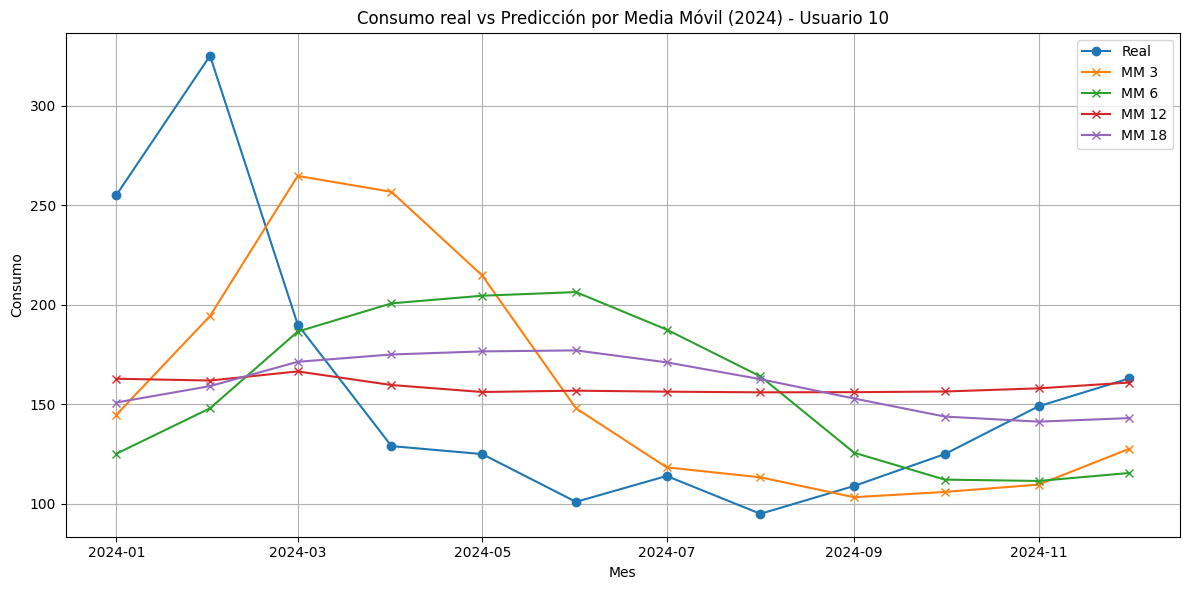

CSV generado: consumo_real_vs_pred_mm_usuario_10_2024.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ================================
# PARAMETROS DE ESTILO (EDITABLES)
# ================================
STYLE = {
    # Tamaños de texto
    "fontsize_title": 16,
    "fontsize_axes": 14,
    "fontsize_ticks": 12,
    "fontsize_legend": 12,

    # Grosor de líneas
    "linewidth_real": 2.5,
    "linewidth_pred": 2.5,

    # Marcadores (opcional)
    "markersize_real": 6,
    "markersize_pred": 6,

    # Otros (opcional)
    "alpha": 0.8
}

# 1. Cargar el archivo
df = pd.read_csv("CON_TEMPU1.csv", sep=';', decimal=',')

# 2. Crear columna de fecha
df['fecha'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str).str.zfill(2) + '-01')
df.sort_values(by=['usuario', 'fecha'], inplace=True)

# 3. Inicializar ventanas móviles
ventanas = [3, 6, 12, 18]

# 4. Crear columnas de medias móviles (shifteadas para evitar leakage)
for ventana in ventanas:
    df[f'mm_{ventana}'] = df.groupby('usuario')['consumo'].transform(
        lambda x: x.shift(1).rolling(window=ventana).mean()
    )

# 5. Validación para 2024: filtrar solo esas fechas
df_2024 = df[df['fecha'].between('2024-01-01', '2024-12-01')].copy()

# 6. Cálculo de errores por ventana
errores = []

for ventana in ventanas:
    col_pred = f'mm_{ventana}'
    df_valid = df_2024[~df_2024[col_pred].isna()]

    mae = mean_absolute_error(df_valid['consumo'], df_valid[col_pred])
    mse = mean_squared_error(df_valid['consumo'], df_valid[col_pred])
    rmse = np.sqrt(mse)

    errores.append({
        'Ventana': ventana,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

# 7. Mostrar tabla de errores
df_errores = pd.DataFrame(errores)
print("Errores de validación para 2024 por ventana de media móvil:")
print(df_errores)

# 8. Predicción para enero de 2025 por usuario
df_enero_2025 = df.groupby('usuario').tail(1).copy()
df_enero_2025['fecha'] = pd.to_datetime('2025-01-01')

for ventana in ventanas:
    pred = df[df['fecha'] < '2025-01-01'].groupby('usuario')['consumo'].apply(
        lambda x: x.tail(ventana).mean()
    )
    df_enero_2025[f'pred_enero_mm_{ventana}'] = df_enero_2025['usuario'].map(pred)

# 9. Graficar consumo real y predicción por usuario (solo 2024)
usuario_ejemplo = df['usuario'].unique()[0]
df_plot = df[df['usuario'] == usuario_ejemplo].copy()
df_plot = df_plot[df_plot['fecha'].between('2024-01-01', '2024-12-01')]

plt.figure(figsize=(12, 6))
plt.plot(df_plot['fecha'], df_plot['consumo'], label='Real', marker='o')

for ventana in ventanas:
    plt.plot(df_plot['fecha'], df_plot[f'mm_{ventana}'], label=f'MM {ventana}', marker='x')

plt.title(f"Consumo real vs Predicción por Media Móvil (2024) - Usuario {usuario_ejemplo}")
plt.xlabel("Mes")
plt.ylabel("Consumo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 10. EXPORTAR A CSV: consumo real vs predicciones (lo graficado)
#     - Separador: ;
#     - Dos decimales
#     - Coma decimal (formato europeo)
# -------------------------------------------------------------------

# Armamos el dataframe a exportar
cols_export = ['fecha', 'consumo'] + [f'mm_{v}' for v in ventanas]
df_export = df_plot[cols_export].copy()

# Renombrar columnas para que quede claro
rename_map = {'consumo': 'consumo_real'}
rename_map.update({f'mm_{v}': f'pred_mm_{v}' for v in ventanas})
df_export.rename(columns=rename_map, inplace=True)

# Formateo: fecha YYYY-MM-DD y números con 2 decimales (coma decimal)
df_export['fecha'] = df_export['fecha'].dt.strftime('%Y-%m-%d')

def fmt_2dec_coma(x):
    if pd.isna(x):
        return ""              # vacío si no hay predicción
    return f"{x:.2f}".replace('.', ',')

for c in df_export.columns:
    if c != 'fecha':
        df_export[c] = df_export[c].apply(fmt_2dec_coma)

# Guardar archivo
output_file = f"consumo_real_vs_pred_mm_usuario_{usuario_ejemplo}_2024.csv"
df_export.to_csv(output_file, sep=';', index=False)

print("CSV generado:", output_file)